In [38]:
import warnings, gc
import numpy as np 
import pandas as pd
import matplotlib.colors
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [39]:
# Read in and construct the initial dataset.

def createDataset(csv):
    temp_ds = pd.read_csv(csv)
    temp_ds.date = pd.to_datetime(temp_ds.date, format="%Y/%m/%d")
    temp_ds = temp_ds.set_index('date')
    print(temp_ds.shape)
    return temp_ds



# Define folder path of source data
#folder_path = "C:/Users/wianc/Desktop/NMRQL/Economic Data/"
folder_path = "C:/Users/Wian/Desktop/Economic Data/"

# Read in description files
annual_desc = pd.read_csv(folder_path + 'annually_description_file.csv')
month_desc = pd.read_csv(folder_path + 'monthly_description_file.csv')
quarterly_desc = pd.read_csv(folder_path + 'quarterly_description_file.csv')

# Read in data files
annual_data = createDataset(folder_path + 'us_economics_annually.csv')
quarterly_data = createDataset(folder_path + 'us_economics_quarterly.csv')
monthly_data = createDataset(folder_path + 'us_economics_monthly.csv')


# Concatenate all data together (with an outer join)
concat_data = pd.concat([monthly_data, quarterly_data, annual_data], axis = 1, join='outer')

# Check that column ids (descriptions references) do not overlap between the different datasets we concatennated.
if len(concat_data.columns.unique()) < len(concat_data.columns): print("Duplicated columns present in data!")

(62, 174)
(250, 442)
(751, 429)


In [40]:
# ["annual_data", "quarterly_data", "monthly_data", "annual_data_description", "quarterly_data_description", "monthly_data_description"]

raw_data = {'annual_data': annual_data,
            'quarterly_data': quarterly_data,
            'monthly_data': monthly_data,
            'annual_data_description': annual_desc,
            'quarterly_data_description': quarterly_desc,
            'monthly_data_description': month_desc
            }
raw_data

{'annual_data':                43684  43687   43696    43706      43709  43710     43716  \
 date                                                                       
 1961-01-01       NaN    4.5     NaN      NaN        NaN    NaN   13.7083   
 1962-01-01       NaN    4.5     NaN      NaN        NaN    NaN   13.8726   
 1963-01-01       NaN    4.5     NaN      NaN        NaN    NaN   14.0446   
 1964-01-01       NaN    4.5     NaN      NaN        NaN    NaN   14.2242   
 1965-01-01       NaN    4.5     NaN      NaN        NaN    NaN   14.4497   
 ...              ...    ...     ...      ...        ...    ...       ...   
 2018-01-01 -596186.0    4.9 -4261.0  58717.0  85.641178    1.0  115.1573   
 2019-01-01 -596263.0    5.3 -6443.0  73626.0  83.673316    2.0  117.2442   
 2020-01-01 -651187.0    3.5 -5487.0 -59565.0        NaN    NaN  118.6905   
 2021-01-01       NaN    3.2 -2446.0      NaN        NaN    NaN  124.2664   
 2022-01-01       NaN    NaN     NaN      NaN        NaN    N

In [ ]:
# Prepare the dataset for dimensionality reduction -
# Join and sample to the same period

# Remove columns with too much missing data. 

# Downsample the monthly data to quarterly data by taking the mean, 
# then linearly interpolate and ffill the ramaining data.

# Impute the remaining missing data.

# Perform Dimensionality Reduction (PCA)


In [41]:
# Check within each dataset that there is enough data. Have a threshold that 
raw_data.keys()
raw_data['annual_data']
concat_data = pd.concat([raw_data['annual_data'], raw_data['quarterly_data'], raw_data['monthly_data']], axis = 1, join = 'outer')


In [42]:
#raw_data['annual_data']

len(raw_data['annual_data']['43684'].dropna())/len(raw_data['annual_data']['43684'])


0.8225806451612904

Dropped 651
Remaining:  394


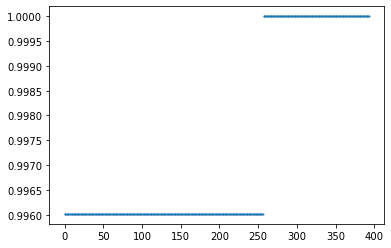

In [43]:
# Check within each dataset that there is enough data. Have a threshold that 
from operator import concat

concat_data = pd.concat([raw_data['annual_data'], raw_data['quarterly_data'], raw_data['monthly_data']], axis = 1, join = 'outer')

concat_data = concat_data.resample(rule='Q', label='right').mean().interpolate('linear').ffill()

olen = len(concat_data.columns)
threshold = 0.01
count = 0
for col in concat_data.columns:
    if concat_data[col].isna().sum()/len(concat_data[col]) > threshold:
        concat_data.drop(col, axis = 1, inplace=True)
        count = count + 1
print("Dropped" , count)
print("Remaining: ", olen - count)


percentage = list()
for col in concat_data.columns: 
    percentage.append(len(concat_data[col].dropna())/len(concat_data[col]))

plt.plot(percentage, 'o', markersize=1)

In [55]:
from operator import concat
from typing import Type


def process_data(raw_data, period = 'Q', threshold = 0.01):
    """
    Transforms, imputes and cleans the datasets to the same period (quarterly by default) with no NaN values.
    
    :returns: pd.DataFrame 
    """

    # Test that raw_data is dictionary
    if not(type(raw_data) is dict):
        raise TypeError("Data must be a dictionary.")


    original_data_config_keys = ["annual_data", "quarterly_data", "monthly_data", "annual_data_description",
                                 "quarterly_data_description", "monthly_data_description"]
    # Check if keys are correct
    if not set(raw_data.keys()) == set(original_data_config_keys):
        raise ValueError(
            "Original 'data_config.json' keys have been changed. Change it back to '" + "', '".join(
                original_data_config_keys) + "'")

    # Test period is correct
    if period not in ['A', 'Q', 'M']:
        raise ValueError("Incorrect Period used, must be 'A' (Annually), 'Q' (Quarterly) or 'M' (Monthly)")

    # Check Threshold is correct
    if not(threshold > 0 and threshold < 1):
        raise ValueError("Threshold value must be a float between 0 and 1") 


    # Join all datasets together
    concat_data = pd.concat([raw_data['annual_data'], raw_data['quarterly_data'], raw_data['monthly_data']], axis = 1, join = 'outer')

    # Resample the joined dataset to the same time period, taking the mean for upsampling and interpolating with downsampling. Finally use ffill for missing values.
    concat_data = concat_data.resample(rule='Q', label='right').mean().interpolate('linear').ffill()

    # Use a threshold value to drop columns with too much missing data.
    olen = len(concat_data.columns)
    count = 0
    size = 0
    for col in concat_data.columns:
        if concat_data[col].isna().sum()/len(concat_data[col]) > threshold:
            concat_data.drop(col, axis = 1, inplace=True)
            count = count + 1
            
    print("Dropped ", count, " columns")
    print("Remaining columns: ", olen - count)


    concat_data

    return concat_data


sampled_data = process_data(raw_data, 'Q')

Dropped  651  columns
Remaining columns:  394


In [56]:
concat_data
for col in concat_data.columns:
    if concat_data[col].isna().sum()/len(concat_data[col]) > threshold:
        concat_data.drop(col, axis = 1, inplace=True)
        count = count + 1



,43684,43687,43696,43706,43709,43710,43716,43724,43725,43726,...,79854,82093,90835,90836,90837,90838,90839,90840,90841,90842
date,,,,,,,,,,,,,,,,,,,,,
1960-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
